In [1]:
##Khai báo các thư viện
from __future__ import print_function
import time
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization,GRU
from keras.datasets import imdb

import os
from keras.preprocessing.text import Tokenizer


Using Theano backend.


In [2]:
## Gán nhãn cho dữ liệu train
X_train = []
y_train = []

path = 'C:/KHOALUAN/DATA/reuter_by_date/train_1d/pos/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])

y_train.extend([1 for _ in range(25835)])

path = 'C:/KHOALUAN/DATA/reuter_by_date/train_1d/neg/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])

y_train.extend([0 for _ in range(18985)])


In [3]:
##Gán nhãn cho dữ liệu test
X_test = []
y_test = []

path = 'C:/KHOALUAN/DATA/reuter_by_date/test_1d/pos/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(25835)])

path = 'C:/KHOALUAN/DATA/reuter_by_date/test_1d/neg/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(18984)])


In [4]:
## Khai báo tham số đặc trưng và chiều dài câu
max_features =5000
max_len = 100  # cut texts after this number of words (among top max_features most common words)

In [5]:
## Xử lý remove stop words cho dữ liệu train
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

X_train_rm= []
stop_words=set(stopwords.words("english"))
for x in X_train:
    words=word_tokenize(x)
    remove_sw= [w for w in words if not w in stop_words]
    X_train_rm.append(remove_sw),
sentence_train=[] 
for i in range(len(X_train_rm)):
    s = ""
    for j in range(len(X_train_rm[i])):
        s+=X_train_rm[i][j]+" "
    sentence_train.append(s),


In [6]:
## Xử lý remove stop words cho dữ liệu test
X_test_rm= []
stop_words=set(stopwords.words("english"))
for x in X_test:
    words=word_tokenize(x)
    remove_sw= [w for w in words if not w in stop_words]

    X_test_rm.append(remove_sw),
sentence_test=[] 
for i in range(len(X_test_rm)):
    s = ""
    for j in range(len(X_test_rm[i])):
        s+=X_test_rm[i][j]+" "
    sentence_test.append(s),


In [7]:
print("Number of words: ")
print(len(np.unique(np.hstack(X_train ))))

Number of words: 
43935


Review length: 
Mean 1319.83 words (676.427567)


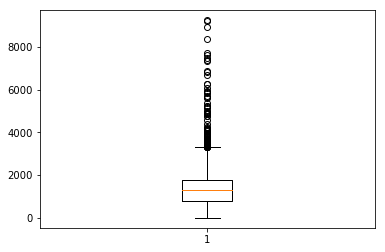

In [8]:
from matplotlib import pyplot
# Summarize review length
print("Review length: ")
result = map(len, X_train)
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [9]:
# Xứ lý tách từ 
imdbTokenizer = Tokenizer(nb_words=max_features)

imdbTokenizer.fit_on_texts(sentence_train)
#for word, value in imdbTokenizer.word_index.items():
    #print(word),


In [10]:
#create int to word dictionary
intToWord = {}
for word, value in imdbTokenizer.word_index.items():
    intToWord[value] = word

#add a symbol for null placeholder
intToWord[0] = "!!!NA!!!"
    
print(intToWord[1])
print(intToWord[2])
print(intToWord[32])


said
new
quarter


In [11]:
#convert word strings to integer sequence lists
#print(X_train[0])
#print(imdbTokenizer.texts_to_sequences(X_train[:1]))
#for value in imdbTokenizer.texts_to_sequences(X_train[:1])[0]:
    #print(intToWord[value])
    
X_train = imdbTokenizer.texts_to_sequences(sentence_train)
X_test = imdbTokenizer.texts_to_sequences(sentence_test)


In [12]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)


44820 train sequences
44819 test sequences
Pad sequences (samples x time)
X_train shape: (44820L, 100L)
X_test shape: (44819L, 100L)


In [13]:
epochs = 3
embedding_neurons = 128
lstm_neurons = 64
batch_size =32


In [14]:
# Forward Pass LSTM Network

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)

# dropout 
after_dp = Dropout(0.5)(forwards)
output = Dense(1, activation='sigmoid')(after_dp)

model_fdir_atom = Model(input=sequence, output=output)
# review model structure
print(model_fdir_atom.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 100, 128)      640000      input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 100, 128)      512         embedding_1[0][0]                
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 64)            37056       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [15]:
# Forward pass LSTM network

# try using different optimizers and different optimizer configs
model_fdir_atom.compile('adam', 'binary_crossentropy', metrics=['accuracy','precision', 'recall', 'fmeasure'])
print('Train...')
start_time = time.time()

history_fdir_atom = model_fdir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)

scores = model_fdir_atom.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

import matplotlib.pyplot as plt
print(history_fdir_atom.history.keys())
# summarize history for accuracy
plt.plot(history_fdir_atom.history['acc'])
plt.plot(history_fdir_atom.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



Train...
Train on 44820 samples, validate on 44819 samples
Epoch 1/3
2100s - loss: 0.6984 - acc: 0.5525 - precision: 0.5822 - recall: 0.7950 - fmeasure: 0.6653 - val_loss: 0.6834 - val_acc: 0.5670 - val_precision: 0.5764 - val_recall: 0.5277 - val_fmeasure: 0.5504
Epoch 2/3
2040s - loss: 0.6730 - acc: 0.5789 - precision: 0.5921 - recall: 0.8663 - fmeasure: 0.6984 - val_loss: 0.6898 - val_acc: 0.5731 - val_precision: 0.5764 - val_recall: 0.5496 - val_fmeasure: 0.5623
Epoch 3/3
2050s - loss: 0.6613 - acc: 0.5977 - precision: 0.6141 - recall: 0.8135 - fmeasure: 0.6944 - val_loss: 0.6942 - val_acc: 0.5821 - val_precision: 0.5765 - val_recall: 0.4907 - val_fmeasure: 0.5291
avg sec per epoch: 2110.865666707
Accuracy: 59,57%


In [17]:
# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 100, 128)      640000      input_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 100, 128)      512         embedding_2[0][0]                
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 64)            37056       batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [18]:
# Bi-directional Atom

# try using different optimizers and different optimizer configs
model_bidir_atom.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy','precision', 'recall', 'fmeasure'])

print('Train...')
start_time = time.time()

history_bidir_atom = model_bidir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)
scores = model_bidir_atom.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

import matplotlib.pyplot as plt
print(history_bidir_atom.history.keys())



Train...
Train on 44820 samples, validate on 44819 samples
Epoch 1/3
3840s - loss: 0.7034 - acc: 0.5491 - precision: 0.5820 - recall: 0.7753 - fmeasure: 0.6576 - val_loss: 0.6864 - val_acc: 0.5748 - val_precision: 0.5764 - val_recall: 0.5664 - val_fmeasure: 0.5712
Epoch 2/3
3720s - loss: 0.6640 - acc: 0.5909 - precision: 0.6085 - recall: 0.8173 - fmeasure: 0.6918 - val_loss: 0.6937 - val_acc: 0.5966 - val_precision: 0.5765 - val_recall: 0.5134 - val_fmeasure: 0.5419
Epoch 3/3
3730s - loss: 0.6417 - acc: 0.6242 - precision: 0.6452 - recall: 0.7757 - fmeasure: 0.6984 - val_loss: 0.7253 - val_acc: 0.6120 - val_precision: 0.5765 - val_recall: 0.4940 - val_fmeasure: 0.5306
avg sec per epoch: 3830.508666674
Accuracy: 61.23%
